# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import torchvision
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from model import *


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Transformations




In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

batch_size = 32

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


CUDA Available? True


shape of each image : torch.Size([3, 32, 32])


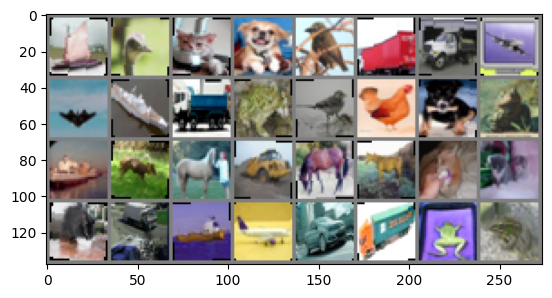

In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f'shape of each image : {images[0].shape}')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Group Norm : Groups 4

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Cifar10_GroupNorm().to(device)
summary(model, input_size=(3, 32, 32))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog 
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
         GroupNorm-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           5,184
              ReLU-6           [-1, 24, 32, 32]               0
         GroupNorm-7           [-1, 24, 32, 32]              48
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             192
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1

# Training and Testing



In [7]:
model =  Cifar10_GroupNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=0)

In [8]:
# Data to plot accuracy and loss graphs

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):

  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  epoch_loss=0


  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)


    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target, reduction='mean')


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    epoch_loss +=loss.item()

    pbar.set_description(desc= f'Batch_id={batch_idx} Batch_Loss={loss.item():0.5f} accuracy={100*correct/processed:0.2f}')


  train_acc.append(100*correct/processed)
  epoch_loss /= len(train_loader)
  train_losses.append(epoch_loss)

  print(f'\nTrain set: Average Loss: {epoch_loss:0.4f} Accuracy : {100*correct/processed:0.2f}%')

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc_ = 100. * correct / len(test_loader.dataset)
  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),test_acc_))

  test_acc.append(test_acc_)
  return test_loss , test_acc_

# Let's Train and test our model with Group Norm



In [9]:
# Custom callback class for model saving and ReduceLROnPlateau
class CustomCallback:
  def __init__(self, model):
      self.model = model
      self.best_loss = float('inf')

  def on_epoch_end(self, epoch, metric):
      # Save the model if validation loss improves
      if metric < self.best_loss:
          self.best_loss = metric
          torch.save(self.model.state_dict(), 'best_model.pth')
          print("Model saved as best_model.pth ")

      # Update the scheduler based on the validation loss
      scheduler.step(metric)


In [10]:
# Train your model and update the learning rate using the scheduler
callback = CustomCallback(model)

EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch} , lr : {optimizer.param_groups[0]['lr']}")

    train(model, device, train_loader, optimizer, epoch)
    test_loss , test_acc_ = test(model, device, test_loader)
    callback.on_epoch_end(epoch, test_loss)


EPOCH : 0 , lr : 0.01


Batch_id=1562 Batch_Loss=1.37641 accuracy=40.97: 100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Train set: Average Loss: 1.6033 Accuracy : 40.97%


Test set: Average loss: 1.3277, Accuracy: 5198/10000 (51.98%)

Model saved as best_model.pth 
EPOCH : 1 , lr : 0.01


Batch_id=1562 Batch_Loss=1.13209 accuracy=55.35: 100%|██████████| 1563/1563 [01:00<00:00, 25.96it/s]


Train set: Average Loss: 1.2422 Accuracy : 55.35%


Test set: Average loss: 1.1328, Accuracy: 5993/10000 (59.93%)

Model saved as best_model.pth 
EPOCH : 2 , lr : 0.01


Batch_id=1562 Batch_Loss=0.94352 accuracy=60.71: 100%|██████████| 1563/1563 [00:59<00:00, 26.27it/s]


Train set: Average Loss: 1.1035 Accuracy : 60.71%


Test set: Average loss: 1.0181, Accuracy: 6379/10000 (63.79%)

Model saved as best_model.pth 
EPOCH : 3 , lr : 0.01


Batch_id=1562 Batch_Loss=1.11319 accuracy=63.84: 100%|██████████| 1563/1563 [00:58<00:00, 26.61it/s]



Train set: Average Loss: 1.0166 Accuracy : 63.84%
Test set: Average loss: 0.9479, Accuracy: 6616/10000 (66.16%)

Model saved as best_model.pth 
EPOCH : 4 , lr : 0.01


Batch_id=1562 Batch_Loss=1.18496 accuracy=66.08: 100%|██████████| 1563/1563 [00:58<00:00, 26.52it/s]


Train set: Average Loss: 0.9592 Accuracy : 66.08%


Test set: Average loss: 0.8993, Accuracy: 6874/10000 (68.74%)

Model saved as best_model.pth 
EPOCH : 5 , lr : 0.01


Batch_id=1562 Batch_Loss=1.07943 accuracy=67.94: 100%|██████████| 1563/1563 [00:57<00:00, 27.10it/s]


Train set: Average Loss: 0.9093 Accuracy : 67.94%


Test set: Average loss: 0.9092, Accuracy: 6786/10000 (67.86%)

EPOCH : 6 , lr : 0.008


Batch_id=1562 Batch_Loss=1.02375 accuracy=70.47: 100%|██████████| 1563/1563 [00:58<00:00, 26.91it/s]


Train set: Average Loss: 0.8480 Accuracy : 70.47%


Test set: Average loss: 0.8117, Accuracy: 7160/10000 (71.60%)

Model saved as best_model.pth 
EPOCH : 7 , lr : 0.008


Batch_id=1562 Batch_Loss=0.91908 accuracy=71.35: 100%|██████████| 1563/1563 [01:02<00:00, 24.93it/s]


Train set: Average Loss: 0.8162 Accuracy : 71.35%


Test set: Average loss: 0.7811, Accuracy: 7263/10000 (72.63%)

Model saved as best_model.pth 
EPOCH : 8 , lr : 0.008


Batch_id=1562 Batch_Loss=0.66283 accuracy=72.36: 100%|██████████| 1563/1563 [01:03<00:00, 24.70it/s]


Train set: Average Loss: 0.7883 Accuracy : 72.36%


Test set: Average loss: 0.7766, Accuracy: 7329/10000 (73.29%)

Model saved as best_model.pth 
EPOCH : 9 , lr : 0.008


Batch_id=1562 Batch_Loss=0.60611 accuracy=73.11: 100%|██████████| 1563/1563 [01:09<00:00, 22.58it/s]


Train set: Average Loss: 0.7680 Accuracy : 73.11%


Test set: Average loss: 0.7476, Accuracy: 7388/10000 (73.88%)

Model saved as best_model.pth 
EPOCH : 10 , lr : 0.008


Batch_id=1562 Batch_Loss=0.68534 accuracy=73.48: 100%|██████████| 1563/1563 [01:09<00:00, 22.52it/s]


Train set: Average Loss: 0.7506 Accuracy : 73.48%


Test set: Average loss: 0.7552, Accuracy: 7409/10000 (74.09%)

EPOCH : 11 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.67116 accuracy=74.71: 100%|██████████| 1563/1563 [01:10<00:00, 22.19it/s]


Train set: Average Loss: 0.7187 Accuracy : 74.71%


Test set: Average loss: 0.7347, Accuracy: 7441/10000 (74.41%)

Model saved as best_model.pth 
EPOCH : 12 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.96305 accuracy=75.55: 100%|██████████| 1563/1563 [01:13<00:00, 21.32it/s]


Train set: Average Loss: 0.7009 Accuracy : 75.55%


Test set: Average loss: 0.7190, Accuracy: 7526/10000 (75.26%)

Model saved as best_model.pth 
EPOCH : 13 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.63106 accuracy=75.87: 100%|██████████| 1563/1563 [01:10<00:00, 22.30it/s]


Train set: Average Loss: 0.6925 Accuracy : 75.87%


Test set: Average loss: 0.6949, Accuracy: 7612/10000 (76.12%)

Model saved as best_model.pth 
EPOCH : 14 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.47542 accuracy=76.43: 100%|██████████| 1563/1563 [01:11<00:00, 21.91it/s]


Train set: Average Loss: 0.6794 Accuracy : 76.43%


Test set: Average loss: 0.7220, Accuracy: 7550/10000 (75.50%)

EPOCH : 15 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.62565 accuracy=77.07: 100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s]


Train set: Average Loss: 0.6584 Accuracy : 77.07%


Test set: Average loss: 0.7114, Accuracy: 7624/10000 (76.24%)

EPOCH : 16 , lr : 0.004096000000000001


Batch_id=1562 Batch_Loss=0.73008 accuracy=77.89: 100%|██████████| 1563/1563 [01:11<00:00, 21.72it/s]


Train set: Average Loss: 0.6329 Accuracy : 77.89%


Test set: Average loss: 0.6769, Accuracy: 7687/10000 (76.87%)

Model saved as best_model.pth 
EPOCH : 17 , lr : 0.004096000000000001


Batch_id=1562 Batch_Loss=1.09579 accuracy=78.36: 100%|██████████| 1563/1563 [01:11<00:00, 21.92it/s]


Train set: Average Loss: 0.6244 Accuracy : 78.36%


Test set: Average loss: 0.6457, Accuracy: 7784/10000 (77.84%)

Model saved as best_model.pth 
EPOCH : 18 , lr : 0.004096000000000001


Batch_id=1562 Batch_Loss=1.19314 accuracy=78.38: 100%|██████████| 1563/1563 [01:11<00:00, 21.87it/s]


Train set: Average Loss: 0.6213 Accuracy : 78.38%


Test set: Average loss: 0.6583, Accuracy: 7759/10000 (77.59%)

EPOCH : 19 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.35459 accuracy=79.19: 100%|██████████| 1563/1563 [01:12<00:00, 21.66it/s]


Train set: Average Loss: 0.6040 Accuracy : 79.19%


Test set: Average loss: 0.6591, Accuracy: 7753/10000 (77.53%)



Text(0.5, 1.0, 'Test Accuracy')

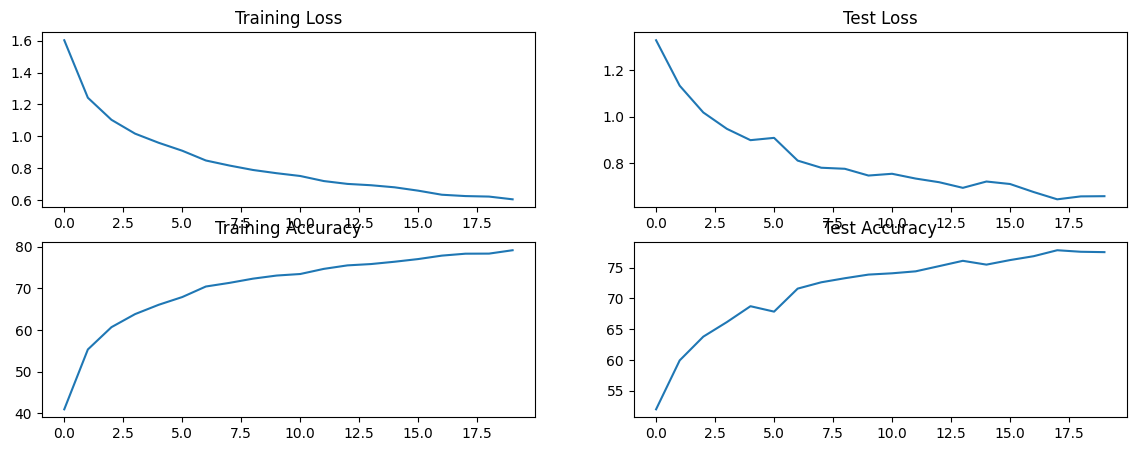

In [11]:
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(14,5))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Incorrect predictions in test data

batch : 0 Incorrect samples : 9
Actual:['cat', 'bird', 'car', 'bird', 'cat', 'bird', 'bird', 'plane', 'plane']
Predicted:['bird', 'plane', 'dog', 'plane', 'bird', 'horse', 'plane', 'deer', 'truck']


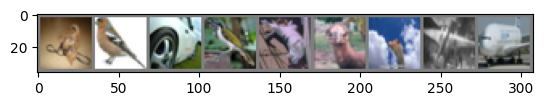

batch : 1 Incorrect samples : 8
Actual:['deer', 'ship', 'bird', 'truck', 'frog', 'cat', 'frog', 'deer']
Predicted:['frog', 'plane', 'frog', 'horse', 'dog', 'bird', 'cat', 'cat']


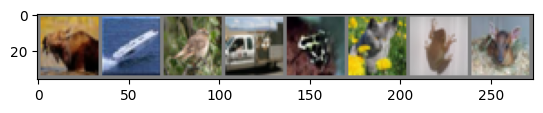

batch : 2 Incorrect samples : 4
Actual:['bird', 'dog', 'horse', 'bird']
Predicted:['deer', 'cat', 'deer', 'cat']


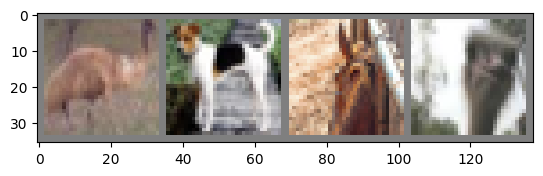

In [12]:
batch=0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    non_matching_values = target[target != pred.view_as(target)]



    if len(non_matching_values)>0:
      print(f'batch : {batch} Incorrect samples : {len(non_matching_values)}')
      data, target , pred  = data.to('cpu'), target.to('cpu') , pred.to('cpu')
      print(f'Actual:{[classes[i] for i in target[target != pred.view_as(target)] ]}')
      print(f'Predicted:{[classes[i] for i in pred[target != pred.view_as(target)]]}')
      imshow(torchvision.utils.make_grid(data[target != pred.view_as(target)],nrow = 10 ))
      batch+=1


    if batch>=3:
      break

# Layer Norm

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Cifar10_LayerNorm().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
         LayerNorm-3           [-1, 24, 32, 32]               0
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           5,184
              ReLU-6           [-1, 24, 32, 32]               0
         LayerNorm-7           [-1, 24, 32, 32]               0
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             192
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,304
             ReLU-12           [-1, 32, 16, 16]               0
        LayerNorm-13           [-1, 32, 16, 16]               0
          Dropout-14           [-1

# Training and Testing

# Let's Train and test our model with Layer Norm



In [14]:
model =  Cifar10_LayerNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=0)

In [15]:
# Data to plot accuracy and loss graphs

train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [16]:
# Train your model and update the learning rate using the scheduler
callback = CustomCallback(model)

EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch} , lr : {optimizer.param_groups[0]['lr']}")

    train(model, device, train_loader, optimizer, epoch)
    test_loss , test_acc_ = test(model, device, test_loader)
    callback.on_epoch_end(epoch, test_loss)

EPOCH : 0 , lr : 0.01


Batch_id=1562 Batch_Loss=1.36514 accuracy=34.89: 100%|██████████| 1563/1563 [01:09<00:00, 22.43it/s]


Train set: Average Loss: 1.7323 Accuracy : 34.89%


Test set: Average loss: 1.4335, Accuracy: 4721/10000 (47.21%)

Model saved as best_model.pth 
EPOCH : 1 , lr : 0.01


Batch_id=1562 Batch_Loss=1.21062 accuracy=49.66: 100%|██████████| 1563/1563 [01:09<00:00, 22.49it/s]


Train set: Average Loss: 1.3713 Accuracy : 49.66%


Test set: Average loss: 1.2253, Accuracy: 5565/10000 (55.65%)

Model saved as best_model.pth 
EPOCH : 2 , lr : 0.01


Batch_id=1562 Batch_Loss=1.59083 accuracy=57.38: 100%|██████████| 1563/1563 [01:19<00:00, 19.70it/s]


Train set: Average Loss: 1.1845 Accuracy : 57.38%


Test set: Average loss: 1.0458, Accuracy: 6275/10000 (62.75%)

Model saved as best_model.pth 
EPOCH : 3 , lr : 0.01


Batch_id=1562 Batch_Loss=0.74976 accuracy=61.83: 100%|██████████| 1563/1563 [01:09<00:00, 22.63it/s]


Train set: Average Loss: 1.0710 Accuracy : 61.83%


Test set: Average loss: 0.9659, Accuracy: 6613/10000 (66.13%)

Model saved as best_model.pth 
EPOCH : 4 , lr : 0.01


Batch_id=1562 Batch_Loss=1.53554 accuracy=64.46: 100%|██████████| 1563/1563 [01:11<00:00, 21.85it/s]


Train set: Average Loss: 0.9928 Accuracy : 64.46%


Test set: Average loss: 0.9326, Accuracy: 6724/10000 (67.24%)

Model saved as best_model.pth 
EPOCH : 5 , lr : 0.01


Batch_id=1562 Batch_Loss=0.58204 accuracy=67.42: 100%|██████████| 1563/1563 [01:10<00:00, 22.05it/s]


Train set: Average Loss: 0.9284 Accuracy : 67.42%


Test set: Average loss: 0.9028, Accuracy: 6819/10000 (68.19%)

Model saved as best_model.pth 
EPOCH : 6 , lr : 0.01


Batch_id=1562 Batch_Loss=0.90296 accuracy=68.84: 100%|██████████| 1563/1563 [01:09<00:00, 22.56it/s]


Train set: Average Loss: 0.8845 Accuracy : 68.84%


Test set: Average loss: 0.8576, Accuracy: 7001/10000 (70.01%)

Model saved as best_model.pth 
EPOCH : 7 , lr : 0.01


Batch_id=1562 Batch_Loss=0.85950 accuracy=70.25: 100%|██████████| 1563/1563 [01:09<00:00, 22.47it/s]


Train set: Average Loss: 0.8459 Accuracy : 70.25%


Test set: Average loss: 0.8611, Accuracy: 6939/10000 (69.39%)

EPOCH : 8 , lr : 0.008


Batch_id=1562 Batch_Loss=1.04467 accuracy=71.83: 100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s]


Train set: Average Loss: 0.7983 Accuracy : 71.83%


Test set: Average loss: 0.7631, Accuracy: 7297/10000 (72.97%)

Model saved as best_model.pth 
EPOCH : 9 , lr : 0.008


Batch_id=1562 Batch_Loss=0.83234 accuracy=72.84: 100%|██████████| 1563/1563 [01:08<00:00, 22.73it/s]


Train set: Average Loss: 0.7742 Accuracy : 72.84%


Test set: Average loss: 0.7549, Accuracy: 7326/10000 (73.26%)

Model saved as best_model.pth 
EPOCH : 10 , lr : 0.008


Batch_id=1562 Batch_Loss=0.77253 accuracy=73.44: 100%|██████████| 1563/1563 [01:09<00:00, 22.53it/s]


Train set: Average Loss: 0.7540 Accuracy : 73.44%


Test set: Average loss: 0.7433, Accuracy: 7401/10000 (74.01%)

Model saved as best_model.pth 
EPOCH : 11 , lr : 0.008


Batch_id=1562 Batch_Loss=0.66424 accuracy=74.13: 100%|██████████| 1563/1563 [01:10<00:00, 22.11it/s]


Train set: Average Loss: 0.7413 Accuracy : 74.13%


Test set: Average loss: 0.7297, Accuracy: 7438/10000 (74.38%)

Model saved as best_model.pth 
EPOCH : 12 , lr : 0.008


Batch_id=1562 Batch_Loss=0.83728 accuracy=74.63: 100%|██████████| 1563/1563 [01:09<00:00, 22.40it/s]


Train set: Average Loss: 0.7257 Accuracy : 74.63%


Test set: Average loss: 0.7209, Accuracy: 7478/10000 (74.78%)

Model saved as best_model.pth 
EPOCH : 13 , lr : 0.008


Batch_id=1562 Batch_Loss=0.82270 accuracy=74.83: 100%|██████████| 1563/1563 [01:09<00:00, 22.51it/s]


Train set: Average Loss: 0.7125 Accuracy : 74.83%


Test set: Average loss: 0.7182, Accuracy: 7483/10000 (74.83%)

Model saved as best_model.pth 
EPOCH : 14 , lr : 0.008


Batch_id=1562 Batch_Loss=0.97214 accuracy=75.37: 100%|██████████| 1563/1563 [01:09<00:00, 22.59it/s]


Train set: Average Loss: 0.7034 Accuracy : 75.37%


Test set: Average loss: 0.6913, Accuracy: 7583/10000 (75.83%)

Model saved as best_model.pth 
EPOCH : 15 , lr : 0.008


Batch_id=1562 Batch_Loss=0.53866 accuracy=75.90: 100%|██████████| 1563/1563 [01:11<00:00, 21.87it/s]


Train set: Average Loss: 0.6914 Accuracy : 75.90%


Test set: Average loss: 0.6841, Accuracy: 7617/10000 (76.17%)

Model saved as best_model.pth 
EPOCH : 16 , lr : 0.008


Batch_id=1562 Batch_Loss=0.93054 accuracy=76.31: 100%|██████████| 1563/1563 [01:09<00:00, 22.51it/s]


Train set: Average Loss: 0.6776 Accuracy : 76.31%


Test set: Average loss: 0.6679, Accuracy: 7650/10000 (76.50%)

Model saved as best_model.pth 
EPOCH : 17 , lr : 0.008


Batch_id=1562 Batch_Loss=0.81326 accuracy=76.37: 100%|██████████| 1563/1563 [01:08<00:00, 22.95it/s]


Train set: Average Loss: 0.6729 Accuracy : 76.37%


Test set: Average loss: 0.6745, Accuracy: 7643/10000 (76.43%)

EPOCH : 18 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.76913 accuracy=77.25: 100%|██████████| 1563/1563 [00:59<00:00, 26.31it/s]


Train set: Average Loss: 0.6470 Accuracy : 77.25%


Test set: Average loss: 0.6419, Accuracy: 7764/10000 (77.64%)

Model saved as best_model.pth 
EPOCH : 19 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.99538 accuracy=77.83: 100%|██████████| 1563/1563 [00:55<00:00, 28.01it/s]



Train set: Average Loss: 0.6371 Accuracy : 77.83%
Test set: Average loss: 0.6480, Accuracy: 7758/10000 (77.58%)



Text(0.5, 1.0, 'Test Accuracy')

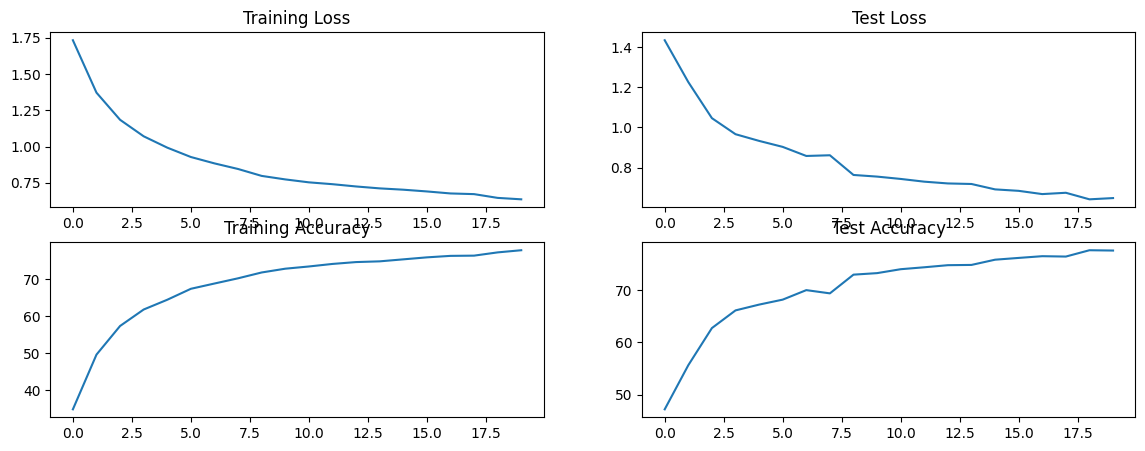

In [17]:
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(14,5))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Incorrect predictions in test data

batch : 0 Incorrect samples : 1
Actual:['dog']
Predicted:['bird']


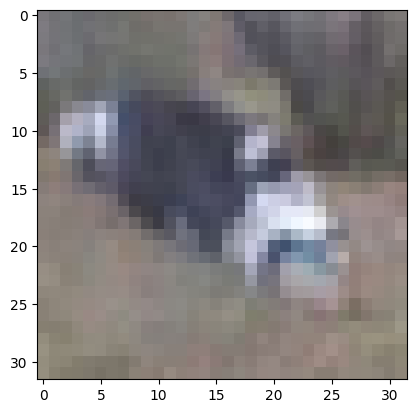

batch : 1 Incorrect samples : 7
Actual:['plane', 'plane', 'cat', 'horse', 'deer', 'cat', 'dog']
Predicted:['truck', 'deer', 'frog', 'cat', 'frog', 'deer', 'cat']


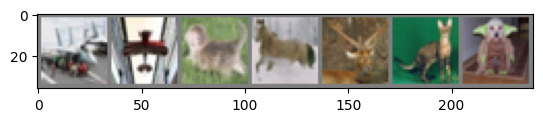

batch : 2 Incorrect samples : 8
Actual:['cat', 'horse', 'plane', 'deer', 'horse', 'deer', 'dog', 'cat']
Predicted:['bird', 'cat', 'dog', 'frog', 'car', 'frog', 'cat', 'frog']


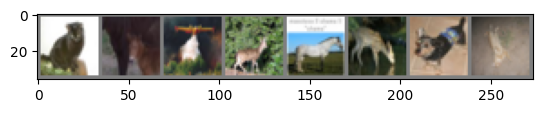

In [18]:
batch=0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    non_matching_values = target[target != pred.view_as(target)]



    if len(non_matching_values)>0:
      print(f'batch : {batch} Incorrect samples : {len(non_matching_values)}')
      data, target , pred  = data.to('cpu'), target.to('cpu') , pred.to('cpu')
      print(f'Actual:{[classes[i] for i in target[target != pred.view_as(target)] ]}')
      print(f'Predicted:{[classes[i] for i in pred[target != pred.view_as(target)]]}')
      imshow(torchvision.utils.make_grid(data[target != pred.view_as(target)],nrow = 10 ))
      batch+=1


    if batch>=3:
      break

# Batch Norm

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Cifar10_BatchNorm().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
       BatchNorm2d-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           5,184
              ReLU-6           [-1, 24, 32, 32]               0
       BatchNorm2d-7           [-1, 24, 32, 32]              48
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             192
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,304
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

# Training and Testing

In [20]:
model =  Cifar10_BatchNorm().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=0)

In [21]:
# Data to plot accuracy and loss graphs

train_losses = []
test_losses = []
train_acc = []
test_acc = []


# Let's Train and test our model with Batch Norm

In [22]:
# Train your model and update the learning rate using the scheduler
callback = CustomCallback(model)

EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch} , lr : {optimizer.param_groups[0]['lr']}")

    train(model, device, train_loader, optimizer, epoch)
    test_loss , test_acc_ = test(model, device, test_loader)
    callback.on_epoch_end(epoch, test_loss)

EPOCH : 0 , lr : 0.01


Batch_id=1562 Batch_Loss=1.23466 accuracy=45.61: 100%|██████████| 1563/1563 [00:54<00:00, 28.55it/s]


Train set: Average Loss: 1.4799 Accuracy : 45.61%


Test set: Average loss: 1.1741, Accuracy: 5683/10000 (56.83%)

Model saved as best_model.pth 
EPOCH : 1 , lr : 0.01


Batch_id=1562 Batch_Loss=2.57022 accuracy=58.77: 100%|██████████| 1563/1563 [00:54<00:00, 28.65it/s]


Train set: Average Loss: 1.1540 Accuracy : 58.77%


Test set: Average loss: 1.0151, Accuracy: 6373/10000 (63.73%)

Model saved as best_model.pth 
EPOCH : 2 , lr : 0.01


Batch_id=1562 Batch_Loss=0.72114 accuracy=63.59: 100%|██████████| 1563/1563 [00:54<00:00, 28.56it/s]


Train set: Average Loss: 1.0201 Accuracy : 63.59%


Test set: Average loss: 0.9075, Accuracy: 6780/10000 (67.80%)

Model saved as best_model.pth 
EPOCH : 3 , lr : 0.01


Batch_id=1562 Batch_Loss=1.32422 accuracy=66.68: 100%|██████████| 1563/1563 [00:54<00:00, 28.55it/s]


Train set: Average Loss: 0.9452 Accuracy : 66.68%


Test set: Average loss: 0.8763, Accuracy: 6914/10000 (69.14%)

Model saved as best_model.pth 
EPOCH : 4 , lr : 0.01


Batch_id=1562 Batch_Loss=1.06448 accuracy=68.56: 100%|██████████| 1563/1563 [00:53<00:00, 29.06it/s]


Train set: Average Loss: 0.8949 Accuracy : 68.56%


Test set: Average loss: 0.8368, Accuracy: 7089/10000 (70.89%)

Model saved as best_model.pth 
EPOCH : 5 , lr : 0.01


Batch_id=1562 Batch_Loss=1.46345 accuracy=70.10: 100%|██████████| 1563/1563 [00:54<00:00, 28.84it/s]


Train set: Average Loss: 0.8550 Accuracy : 70.10%


Test set: Average loss: 0.7475, Accuracy: 7399/10000 (73.99%)

Model saved as best_model.pth 
EPOCH : 6 , lr : 0.01


Batch_id=1562 Batch_Loss=0.81597 accuracy=71.08: 100%|██████████| 1563/1563 [00:56<00:00, 27.84it/s]


Train set: Average Loss: 0.8189 Accuracy : 71.08%


Test set: Average loss: 0.7282, Accuracy: 7481/10000 (74.81%)

Model saved as best_model.pth 
EPOCH : 7 , lr : 0.01


Batch_id=1562 Batch_Loss=0.89191 accuracy=72.43: 100%|██████████| 1563/1563 [00:55<00:00, 28.26it/s]


Train set: Average Loss: 0.7915 Accuracy : 72.43%


Test set: Average loss: 0.7386, Accuracy: 7435/10000 (74.35%)

EPOCH : 8 , lr : 0.008


Batch_id=1562 Batch_Loss=1.09929 accuracy=73.59: 100%|██████████| 1563/1563 [00:58<00:00, 26.77it/s]


Train set: Average Loss: 0.7514 Accuracy : 73.59%


Test set: Average loss: 0.6779, Accuracy: 7607/10000 (76.07%)

Model saved as best_model.pth 
EPOCH : 9 , lr : 0.008


Batch_id=1562 Batch_Loss=0.88210 accuracy=74.19: 100%|██████████| 1563/1563 [00:59<00:00, 26.19it/s]


Train set: Average Loss: 0.7362 Accuracy : 74.19%


Test set: Average loss: 0.6878, Accuracy: 7618/10000 (76.18%)

EPOCH : 10 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.48373 accuracy=75.21: 100%|██████████| 1563/1563 [01:07<00:00, 23.02it/s]


Train set: Average Loss: 0.7075 Accuracy : 75.21%


Test set: Average loss: 0.6523, Accuracy: 7755/10000 (77.55%)

Model saved as best_model.pth 
EPOCH : 11 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.48095 accuracy=76.23: 100%|██████████| 1563/1563 [01:00<00:00, 25.70it/s]


Train set: Average Loss: 0.6850 Accuracy : 76.23%


Test set: Average loss: 0.6364, Accuracy: 7809/10000 (78.09%)

Model saved as best_model.pth 
EPOCH : 12 , lr : 0.0064


Batch_id=1562 Batch_Loss=0.69080 accuracy=76.10: 100%|██████████| 1563/1563 [00:59<00:00, 26.10it/s]


Train set: Average Loss: 0.6830 Accuracy : 76.10%


Test set: Average loss: 0.6492, Accuracy: 7759/10000 (77.59%)

EPOCH : 13 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.73164 accuracy=77.06: 100%|██████████| 1563/1563 [00:58<00:00, 26.65it/s]


Train set: Average Loss: 0.6579 Accuracy : 77.06%


Test set: Average loss: 0.6207, Accuracy: 7863/10000 (78.63%)

Model saved as best_model.pth 
EPOCH : 14 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.80662 accuracy=77.41: 100%|██████████| 1563/1563 [01:00<00:00, 25.95it/s]


Train set: Average Loss: 0.6523 Accuracy : 77.41%


Test set: Average loss: 0.6013, Accuracy: 7921/10000 (79.21%)

Model saved as best_model.pth 
EPOCH : 15 , lr : 0.00512


Batch_id=1562 Batch_Loss=0.63096 accuracy=77.46: 100%|██████████| 1563/1563 [01:02<00:00, 25.09it/s]


Train set: Average Loss: 0.6442 Accuracy : 77.46%


Test set: Average loss: 0.6076, Accuracy: 7920/10000 (79.20%)

EPOCH : 16 , lr : 0.004096000000000001


Batch_id=1562 Batch_Loss=0.94026 accuracy=78.08: 100%|██████████| 1563/1563 [01:04<00:00, 24.27it/s]


Train set: Average Loss: 0.6309 Accuracy : 78.08%


Test set: Average loss: 0.6059, Accuracy: 7931/10000 (79.31%)

EPOCH : 17 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.57309 accuracy=78.45: 100%|██████████| 1563/1563 [01:03<00:00, 24.46it/s]


Train set: Average Loss: 0.6150 Accuracy : 78.45%


Test set: Average loss: 0.5865, Accuracy: 8001/10000 (80.01%)

Model saved as best_model.pth 
EPOCH : 18 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.46587 accuracy=78.78: 100%|██████████| 1563/1563 [01:05<00:00, 23.70it/s]


Train set: Average Loss: 0.6111 Accuracy : 78.78%


Test set: Average loss: 0.5793, Accuracy: 8012/10000 (80.12%)

Model saved as best_model.pth 
EPOCH : 19 , lr : 0.0032768000000000007


Batch_id=1562 Batch_Loss=0.36957 accuracy=78.85: 100%|██████████| 1563/1563 [01:07<00:00, 23.21it/s]


Train set: Average Loss: 0.6062 Accuracy : 78.85%


Test set: Average loss: 0.5703, Accuracy: 8066/10000 (80.66%)

Model saved as best_model.pth 


Text(0.5, 1.0, 'Test Accuracy')

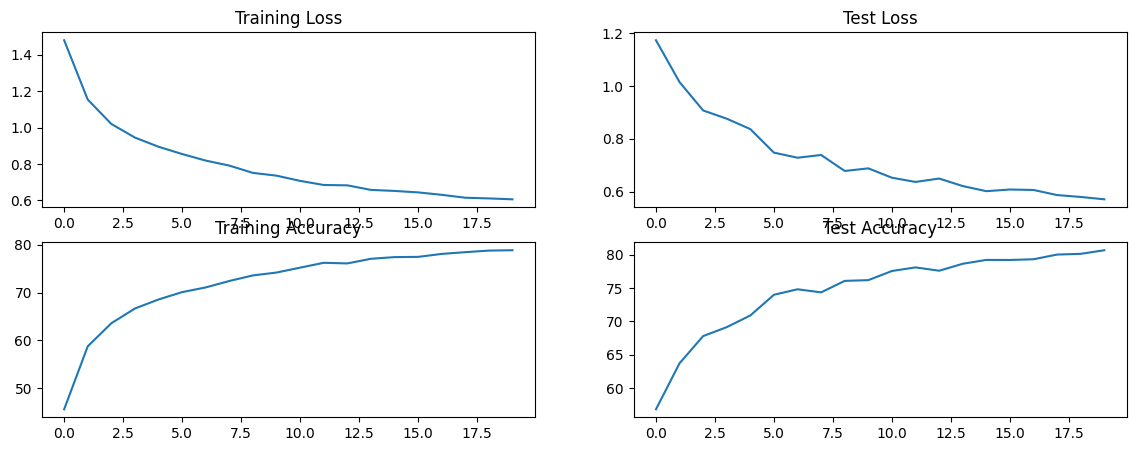

In [23]:
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(14,5))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Incorrect predictions in test data

batch : 0 Incorrect samples : 3
Actual:['cat', 'ship', 'deer']
Predicted:['dog', 'car', 'frog']


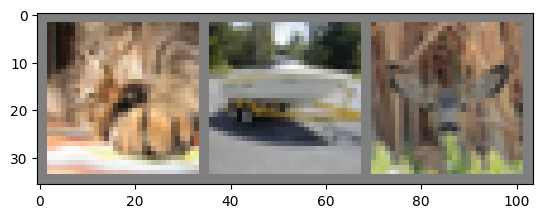

batch : 1 Incorrect samples : 4
Actual:['bird', 'frog', 'dog', 'ship']
Predicted:['ship', 'bird', 'cat', 'cat']


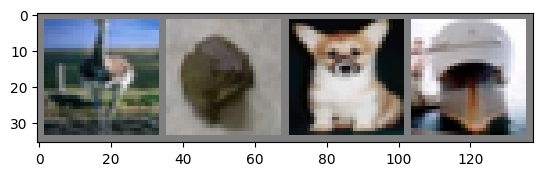

batch : 2 Incorrect samples : 4
Actual:['cat', 'cat', 'dog', 'deer']
Predicted:['dog', 'dog', 'bird', 'bird']


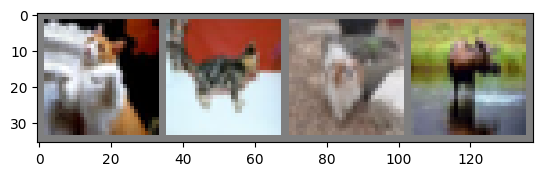

In [24]:
batch=0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)

    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    non_matching_values = target[target != pred.view_as(target)]



    if len(non_matching_values)>0:
      print(f'batch : {batch} Incorrect samples : {len(non_matching_values)}')
      data, target , pred  = data.to('cpu'), target.to('cpu') , pred.to('cpu')
      print(f'Actual:{[classes[i] for i in target[target != pred.view_as(target)] ]}')
      print(f'Predicted:{[classes[i] for i in pred[target != pred.view_as(target)]]}')
      imshow(torchvision.utils.make_grid(data[target != pred.view_as(target)],nrow = 10 ))
      batch+=1


    if batch>=3:
      break